<h1><center>Notebook 0 : ERA5 pretreatment</center></h1>

<h2>Instructions for this notebook</h2>


This notebook was written by Paul Platzer. It accompanies the following scientific publication:<br>
"Disentangling Density and Geometry in Weather Regime Dimensions using Stochastic Twins"<br>
By Paul Platzer, Bertrand Chapron, and Gabriele Messori.<br>
<b> add doi, date...etc. </b>

It is part of six notebooks that allow to reproduce the figures of the article. It must be used in conjunction with 500mb geopotential height data from ERA5 (last download from october 18th, 2023), as specified in the body text of the article.

What this notebook does:

<ol>
    <li> It opens raw ERA5, twice-daily geopotential height data.</li>
    <li> It computes daily climatology and anomaly based on the above.</li>
    <li> It computes a 10-days moving average of anomalies.</li>
    <li> It computes winter-time empirical orthogonal functions (EOFs) of the smoothed anomalies.</li>
    <li> It stores climatology and EOF-related properties and projections.</li>
</ol>

To use properly this notebook, you must:

<ol>
    <li> Run first sections I.A., I.B.. This will compute the climatology that you need to further compute the anomalies, and save it for later. </li>
    <li> Then re-run everything but section I.B. </li>
</ol>

Note that, for this code to work on your machine, you should:

<ol>
    <li> Have download the libraries listed in the first two cells. </li>
    <li> Use python 3 : this code was tested using python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0] </li>
    <li> Have enough memory and computing resources. If not, you might have to modify the code to make it work. The code was run using a Dell Inc. Precision 7550 which has 33G of RAM and setting the same amount of swap space, and for processing we have Intel® Core™ i7-10875H CPU @ 2.30GHz × 16, with graphics card NVIDIA Corporation TU104GLM [Quadro RTX 4000 Mobile / Max-Q] / Mesa Intel® UHD Graphics (CML GT2). </li>
</ol>

In [1]:
import sys
print(sys.version)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]


In [2]:
import numpy as np
import xarray as xr
from eofs.xarray import Eof
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm

In [3]:
cols = ['k', '#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

In [4]:
# folders where data and figures generated through this notebook will be stored
data_folder = '../outputs/data/'
figure_folder = '../outputs/figures/'

# I. Load and preprocess ERA5 data

## I.A. Load

In [5]:
ERA5_folder = '/home/pplatzer/Documents/pro/postdoc/DATA/ERA5/'
file = 'ERA5_z500_1979_2023.grib'

In [6]:
ds = xr.open_dataset(ERA5_folder+file, engine='cfgrib')

In [7]:
# read the longitude and latitude (we will use the latitude to weight the EOFs)
lon = ds['longitude']
lat = ds['latitude']
LON, LAT = np.meshgrid(lon, lat)

## I.B. Compute climatology
Skip this part if already pre-computed and stored.

Since the data is large (~17GB), we use a loop over "dayofyear" to reduce memory usage when computing the climatology.

In [7]:
# Extract the day of the year
day_of_year = ds['time'].dt.dayofyear

In [ ]:
# Initialize an empty dictionary to hold the sums and counts for each day of the year
doy_sums = {}
doy_counts = {}

# Loop over each unique day of year
for doy in tqdm( np.unique(day_of_year) ):
    # Select data for the current day of year
    doy_data = ds.sel(time=ds['time'].dt.dayofyear == doy)
    
    # Compute the sum and count incrementally for the current day
    if doy not in doy_sums:
        doy_sums[doy] = doy_data.sum(dim='time')
        doy_counts[doy] = doy_data['time'].size
    else:
        doy_sums[doy] += doy_data.sum(dim='time')
        doy_counts[doy] += doy_data['time'].size

  0%|          | 0/366 [00:00<?, ?it/s]

In [ ]:
# Create an empty list to store climatology for each day of year
climatology = []

# Compute climatology by dividing sums by counts
for doy in sorted(doy_sums.keys()):
    climatology.append(doy_sums[doy] / doy_counts[doy])

# Combine the climatology into a single xarray dataset
climatology_ds = xr.concat(climatology, dim='dayofyear')
climatology_ds['dayofyear'] = list(doy_sums.keys())

# Now you have the climatology dataset
print(climatology_ds)

In [ ]:
climatology_ds.to_netcdf(ERA5_folder + 'ERA5_z500_clim_1979_2023.nc')

## I.C. Load climatology
If already computed.

In [8]:
ds_clim = xr.open_dataset(ERA5_folder + 'ERA5_z500_clim_1979_2023.nc')

## I.D. Compute anomaly

In [9]:
ds = ds.assign_coords(dayofyear=ds['time'].dt.dayofyear)

In [10]:
z_anom = ds['z'].copy()
dt_comp = np.timedelta64(int(2*365),'D')
t0 = ds.time[0]
while t0 < ds.time[-1]:
    t1 = t0.copy() + dt_comp
    print('Computing anomaly from time '+str(np.array(t0))+' to '+str(np.array(t1)))
          
    z_anom.loc[t0:t1] = ( ds['z'].sel(time=slice(t0,t1)) - ds_clim['z'].sel(dayofyear=ds['dayofyear'].sel(time=slice(t0,t1))) ).values
    t0 += dt_comp

Computing anomaly from time 1979-01-01T00:00:00.000000000 to 1980-12-31T00:00:00.000000000


KeyboardInterrupt: 

## I.E. Time-smoothing

In [ ]:
za_smooth = z_anom.rolling(time=2*10, center=True).mean().dropna('time') # 10 days rolling average

## I.F. Save time and day of year

In [7]:
# save the 'day of year' variable which will be used later for dimension diagnostics
# here we use a dummy variable which has the same 'time' index as 'za_smooth'
z_smooth_dummy = ds.z.isel(latitude=0,longitude=0).rolling(time=2*10, center=True).mean().dropna('time') # 10 days rolling average

In [12]:
time_arr = np.array(z_smooth_dummy.isel(time = (z_smooth_dummy.time.dt.season == 'DJF')).time)
doy_arr = np.array(z_smooth_dummy.isel(time = (z_smooth_dummy.time.dt.season == 'DJF')).time.dt.dayofyear)

In [17]:
# save
np.savez(data_folder + 'time_doy.npz', time_arr = time_arr, doy_arr = doy_arr)

# II. Compute EOFs

In [16]:
# /!\ LONG TO COMMPUTE (a few minutes)
# apply the EOF decomposition (latitude weights are applied before the computation of EOFs)

za_compute_EOF = ( za_smooth.resample(time='15D').nearest(tolerance='1D') )
    solver = Eof( ( za_compute_EOF.isel(time = (za_compute_EOF.time.dt.season == 'DJF')) ).load(), # subsample to make computation faster
             weights=np.sqrt(np.cos(np.deg2rad(LAT))))

In [17]:
# retrieve the first EOFs from the solver class
Neofs = 65
eofs = solver.eofs(neofs=Neofs)
pourc_EOF = solver.varianceFraction(neigs=Neofs)
var_expl = np.array(   [ np.sum(pourc_EOF[:i]) for i in range(len(pourc_EOF)) ]   )

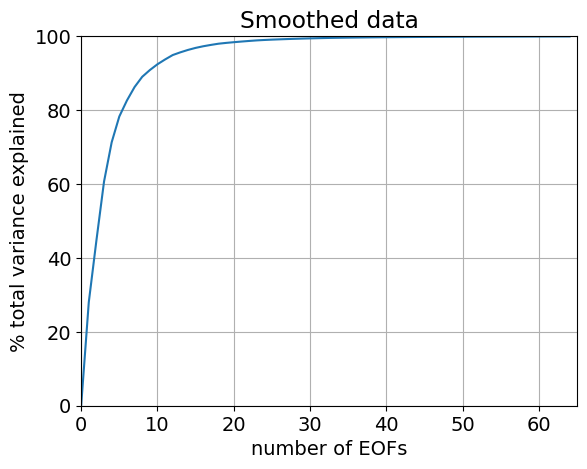

In [12]:
plt.figure()
plt.plot( np.arange(Neofs), 100*var_expl )
plt.grid(); plt.xlim(0,Neofs); plt.ylim(0,100)
plt.ylabel('% total variance explained')
plt.xlabel('number of EOFs')
plt.show()

In [18]:
eigenval = solver.eigenvalues(neigs=Neofs)

In [19]:
allpcs =  solver.projectField(za_smooth.isel(time = (za_smooth.time.dt.season == 'DJF')), neofs=Neofs)

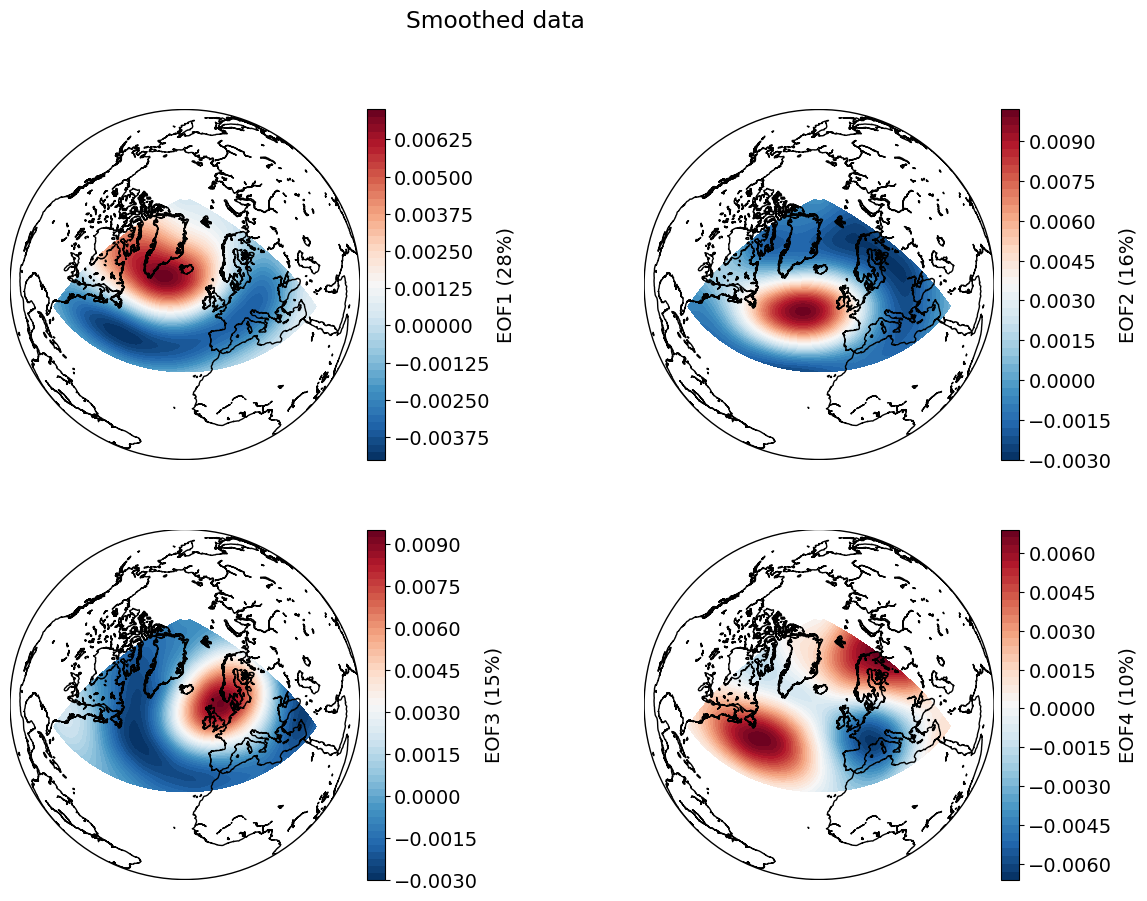

In [16]:
plt.figure(figsize=(15,10))

# Orthogonal projection (for large zone)
m=Basemap(projection='ortho',lat_0=60,lon_0=-20,resolution='l')

# transform (lon, lat) to (x, y) in the chosen projection
x, y = m(LON, LAT)

# plot the 4 first EOFs
for i in range(4):
    plt.subplot(2,2,i+1)
    m.contourf(x, y, eofs[i,:,:], cmap = 'RdBu_r', levels=50)
    m.drawcoastlines()
    cb = m.colorbar(location="right")
    cb.set_label("EOF" + str(i+1) + " (" + str(int(pourc_EOF.values[i]*100)) + "%)")

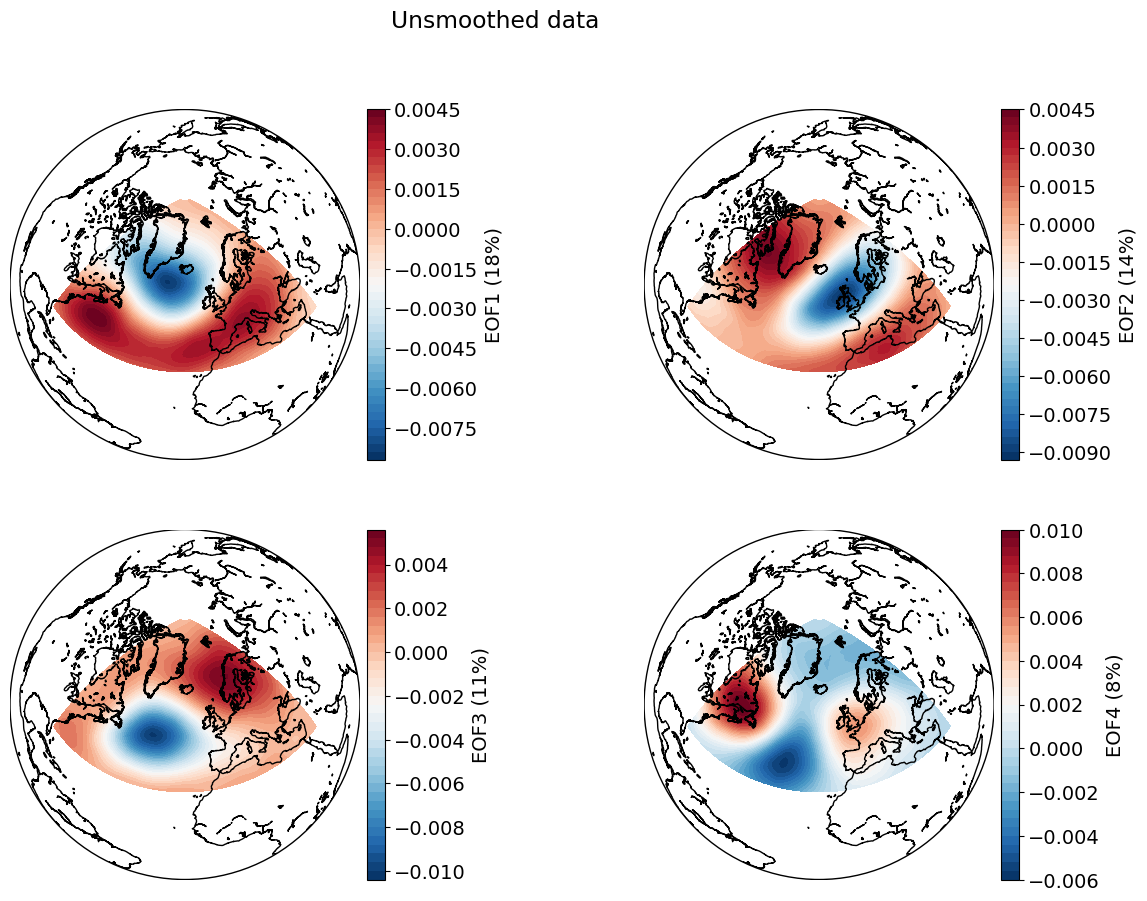

In [33]:
plt.figure(figsize=(15,10))

# Orthogonal projection (for large zone)
m=Basemap(projection='ortho',lat_0=60,lon_0=-20,resolution='l')

# transform (lon, lat) to (x, y) in the chosen projection
x, y = m(LON, LAT)

# plot the 4 first EOFs
for i in range(4):
    plt.subplot(2,2,i+1)
    m.contourf(x, y, eofs[i,:,:], cmap = 'RdBu_r', levels=50)
    m.drawcoastlines()
    cb = m.colorbar(location="right")
    cb.set_label("EOF" + str(i+1) + " (" + str(int(pourc_EOF.values[i]*100)) + "%)")

In [17]:
# Save
allpcs.to_netcdf('../outputs/data/pcs.nc')
eofs.to_netcdf('../outputs/data/eofs.nc')
pourc_EOF.to_netcdf('../outputs/data/pourc_eofs.nc')
eigenval.to_netcdf('../outputs/data/eigenval.nc')

In [13]:
# for test
pourc_EOF = xr.open_dataset('../outputs/data/pourc_eofs.nc')['variance_fractions']

In [14]:
var_expl = np.array(   [ np.sum(pourc_EOF[:i]) for i in range(len(pourc_EOF)) ]   )

In [16]:
var_expl[64]

0.99911153